In [1]:
#import astropy
#import sklearn
#from astropy.io import fits
from math import pi, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt
#from matplotlib.pyplot import plot, scatter, show
from time import time
import numpy as np
import pandas as pd
import os
#from Cylindrical_Map_Transformation import get_header_params_MDI, map_disk_cylindric, get_header_params_HMI
from collections import Counter,defaultdict
#import astropy.convolution
#from astropy.convolution import convolve_fft, convolve
%matplotlib inline

In [2]:
import sklearn.metrics.cluster as metrics 
from sklearn.cluster import KMeans

In [1]:
import hdbscan

In [3]:
import plotly.plotly as py

In [3]:
from extract_feautres_script import get_active_region_map, get_active_region_labels

In [4]:
def plot_image(image):
    plt.figure(figsize = (10,10));
    test_plot_diff  = np.ma.masked_where(image == 0.0, image)
    plt.imshow(test_plot_diff, interpolation='none', origin='lower');
    plt.title("Gaussian2DKernel")
    plt.xlabel("X Pixels")
    plt.ylabel("Y Pixels")
    #plt.colorbar()
    plt.xlim((600,700))
    plt.ylim((600,660))
    plt.show()

In [5]:
def map_imagePixels_to_euclidian_space(image, smoothing):
    x_coords = []
    y_coords = []
    z_coords = []
    coords = []
    for i, row in enumerate(np.abs(image)):
        for j, col in enumerate(row):
            if smoothing[i,j] == 1:
                x_coords.append(i)
                y_coords.append(j)
                z_coords.append(col)
                coords.append([i,j,col])
    return x_coords, y_coords, z_coords, coords

In [6]:
def plot_cluster(x_coords, y_coords, z_coords):
    scatter = dict(
    mode = "markers",
    name = "y",
    type = "scatter3d",    
    x =x_coords, y = y_coords, z = z_coords,
    marker = dict( size=2, color="rgb(23, 190, 207)" )
    )
    clusters = dict(
        alphahull = 7,
        name = "y",
        opacity = 0.1,
        type = "mesh3d",    
        x = x_coords, y = y_coords, z = z_coords
    )
    layout = dict(
        title = '3d point clustering',
        scene = dict(
            xaxis = dict( zeroline=False ),
            yaxis = dict( zeroline=False ),
            zaxis = dict( zeroline=False ),
        )
    )
    fig = dict( data=[scatter, clusters], layout=layout )
    # Use py.iplot() for IPython notebook
    url = py.iplot(fig, filename='3d point clustering')
    return url

###Import and pre-process sample image

In [7]:
path = "/Users/Alexander/NASA/NASA_Sample_Data/"
image_file = "fd_M_96m_01d.6543.0000.fits"
active_region_image = get_active_region_map(path, image_file)

In [8]:
active_region_labels = get_active_region_labels(active_region_image[0])

In [10]:
x, y, z = map_imagePixels_to_euclidian_space(active_region_image[0], active_region_labels)

In [12]:
plot_cluster(x, y, z)

###Apply K-Means

In [13]:
from scipy.cluster.vq import whiten
from scipy.cluster.vq import kmeans,vq

In [124]:
X = pd.DataFrame({'x':x,'y':y,'z':z}).values
# scale data for unit variance doesn't provide an obvious advantage
#X = whiten(X)

In [76]:
X

array([[ 610.        ,  666.        ,  367.        ],
       [ 610.        ,  667.        ,  363.        ],
       [ 610.        ,  668.        ,  309.        ],
       ..., 
       [ 645.        ,  648.        ,   19.43393561],
       [ 645.        ,  649.        ,   41.10080021],
       [ 645.        ,  650.        ,   35.06984746]])

In [19]:
def get_cluster_data(X, n):
    K = range(1,n + 1)
    centroids = []   # cluster centroids
    labels = []   # cluster variance
    var = []   # cluster variance
    for k in K:
        kmeans = KMeans(k)
        kmeans.fit(X)
        labels.append(kmeans.predict(X))
        var.append(kmeans.inertia_)
        centroids.append(kmeans.cluster_centers_)
    # mean within-cluster sum of square
    avgWithinSS = [v /X.shape[0] for v in var] 
    return centroids, np.array(labels), var, avgWithinSS

In [20]:
##### cluster data into K=1..10 clusters #####
n = 8
centroids, labels, var, avgWithinSS = get_cluster_data(X,n)

In [21]:
labels[0].shape

(1803,)

###Thought on the Elbow Curve
    Explore the possibility of using this curve to choose k by locating the first ith cluster 
    that dropped in aveWithinSS lest than the i - 1 cluster, then choose the i - 1 cluster as
    our k. 
    
    In the sample image, k = 2

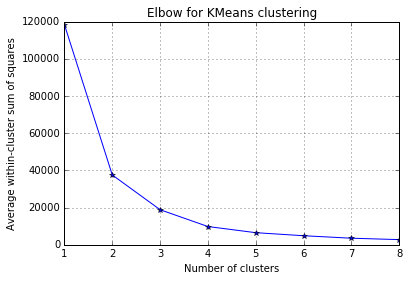

In [22]:
# elbow curve
kIdx = 2
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(1, n+1), avgWithinSS, 'b*-')
plt.grid(True);
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares');
plt.title('Elbow for KMeans clustering');

###Explore Metrics

In [127]:
print X.shape
print labels.T.shape[0]

(1803, 3)
1803


In [131]:
sil_score = [metrics.silhouette_score(X,label) for label in labels]

In [132]:
sil_score

[0.65113870530355611,
 0.65868814043964719,
 0.60249034038764149,
 0.56763784693283537,
 0.56725820255854575,
 0.54043529281520686,
 0.52456446697031178]

In [25]:
import random
# will likely have to implement my own version of the Gap Statistic 
def cluster_points(X, mu):
    clusters  = {}
    for x in X:
        bestmukey = min([(i[0], np.linalg.norm(x-mu[i[0]])) \
                    for i in enumerate(mu)], key=lambda t:t[1])[0]
        try:
            clusters[bestmukey].append(x)
        except KeyError:
            clusters[bestmukey] = [x]
    return clusters
 
def reevaluate_centers(mu, clusters):
    newmu = []
    keys = sorted(clusters.keys())
    for k in keys:
        newmu.append(np.mean(clusters[k], axis = 0))
    return newmu
 
def has_converged(mu, oldmu):
    return (set([tuple(a) for a in mu]) == set([tuple(a) for a in oldmu]))
 
def find_centers(X, K):
    import random
    # Initialize to K random centers
    oldmu = random.sample(X, K)
    mu = random.sample(X, K)
    while not has_converged(mu, oldmu):
        oldmu = mu
        # Assign all points in X to clusters
        clusters = cluster_points(X, mu)
        # Reevaluate centers
        mu = reevaluate_centers(oldmu, clusters)
    return(mu, clusters)

def Wk(mu, clusters):
    K = len(mu)
    return sum([np.linalg.norm(mu[i]-c)**2/(2*len(c)) \
               for i in range(K) for c in clusters[i]])
def bounding_box(X):
    xmin, xmax = min(X,key=lambda a:a[0])[0], max(X,key=lambda a:a[0])[0]
    ymin, ymax = min(X,key=lambda a:a[1])[1], max(X,key=lambda a:a[1])[1]
    return (xmin,xmax), (ymin,ymax)
 
def gap_statistic(X):
    from numpy import zeros
    (xmin,xmax), (ymin,ymax) = bounding_box(X)
    print "bounding_box success"
    # Dispersion for real distribution
    ks = range(1,10)
    Wks = zeros(len(ks))
    Wkbs = zeros(len(ks))
    sk = zeros(len(ks))
    for indk, k in enumerate(ks):
        mu, clusters = find_centers(X,k)
        print "find_centers success"
        Wks[indk] = np.log(Wk(mu, clusters))
        # Create B reference datasets
        B = 10
        BWkbs = zeros(B)
        for i in range(B):
            Xb = []
            for n in range(len(X)):
                Xb.append([random.uniform(xmin,xmax),
                          random.uniform(ymin,ymax)])
            Xb = np.array(Xb)
            mu, clusters = find_centers(Xb,k)
            BWkbs[i] = np.log(Wk(mu, clusters))
        Wkbs[indk] = sum(BWkbs)/B
        sk[indk] = np.sqrt(sum((BWkbs-Wkbs[indk])**2)/B)
    sk = sk*np.sqrt(1+1/B)
    return(ks, Wks, Wkbs, sk)

In [45]:
def init_board_gauss(N, k):
    n = float(N)/k
    X = []
    for i in range(k):
        c = (random.uniform(-1, 1), random.uniform(-1, 1))
        s = random.uniform(0.05,0.5)
        x = []
        while len(x) < n:
            a, b = np.array([np.random.normal(c[0], s), np.random.normal(c[1], s)])
            # Continue drawing points from the distribution in the range [-1,1]
            if abs(a) < 1 and abs(b) < 1:
                x.append([a,b])
        X.extend(x)
    X = np.array(X)[:N]
    return X

###Try Gap Stat with X 


In [77]:
# try the gap stat with X (all of the coordinates)
# ks, logWks, logWkbs, sk
ks, logWks, logWkbs, sk = gap_statistic(X)

bounding_box success
find_centers success
find_centers success
find_centers success
find_centers success
find_centers success
find_centers success
find_centers success
find_centers success
find_centers success


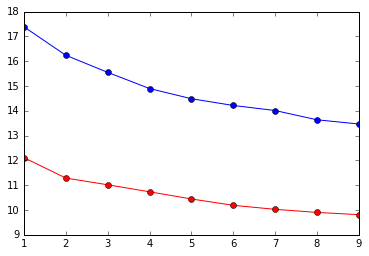

In [79]:
plt.plot(ks, logWks, 'bo-');
plt.plot(ks, logWkbs, 'ro-');

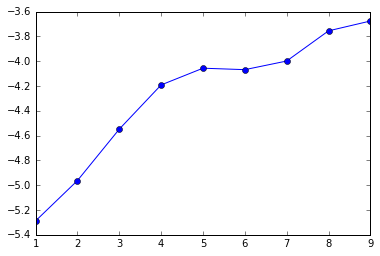

In [106]:
# Choose the number of clusters as the smallest k 
# such that \mathrm{Gap}(k) \geq \mathrm{Gap}(k+1) - s_{k+1}.
plt.plot(ks,(logWkbs - logWks ) - sk, 'bo-');

In [116]:
def get_k(ks, logWks, logWkbs, sk):
    for k in ks:
        #k = k -1
        if k == 1:
            gap_k = logWkbs[k] - logWks[k]

        else:
            gap_k_1 = logWkbs[k] - logWks[k]
            if gap_k > gap_k_1 - sk[k]:
                return  gap_k, k 
            else:
                gap_k = gap_k_1

###Try Gap Stat with XZ slice

In [114]:
X = pd.DataFrame({'x':x, 'z':z}).values
ks, logWks, logWkbs, sk = gap_statistic(X)

bounding_box success
find_centers success
find_centers success
find_centers success
find_centers success
find_centers success
find_centers success
find_centers success
find_centers success
find_centers success


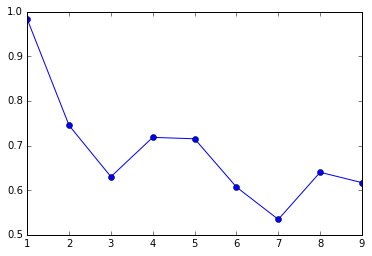

In [115]:
# this xz slice would choose 2 as k 
plt.plot(ks,(logWkbs - logWks ) - sk, 'bo-');

In [117]:
get_k(ks, logWks, logWkbs, sk)

(0.76494686636886655, 2)

###Try Gap Stat with YZ slice

In [118]:
X = pd.DataFrame({'y':y, 'z':z}).values
ks, logWks, logWkbs, sk = gap_statistic(X)

bounding_box success
find_centers success
find_centers success
find_centers success
find_centers success
find_centers success
find_centers success
find_centers success
find_centers success
find_centers success


(0.76420444628451634, 2)


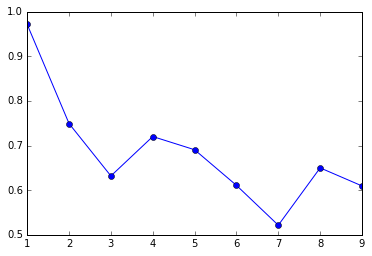

In [119]:
plt.plot(ks,(logWkbs - logWks ) - sk, 'bo-');
print get_k(ks, logWks, logWkbs, sk)

###Gap Statistic Conclusion
    The gap statistic is unreliable when all 3 dimensions are used as the input data. 
    The statistic may be reliable in XZ/YZ slices. Further experimentation is needed. 
    
    Note: Saddle points may be a problem for XZ/YZ scans of densities 

###Assuming that the Gap Statistic is Reliable...

In [60]:
from sklearn.mixture import GMM

In [84]:
gmm = GMM(2)#, covariance_type = 'full')

In [85]:
labels = gmm.fit_predict(np.abs(X))

In [86]:
np.unique(labels)

array([0, 1])

In [87]:
X.shape

(1803, 3)

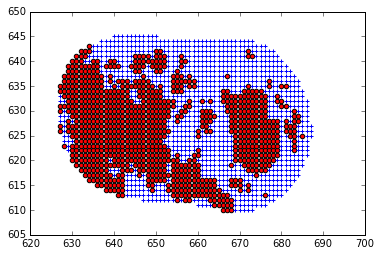

In [88]:
for xyz, label in zip(X, labels):
    if label == 0:
        plt.scatter(xyz[1], xyz[0], c='b',marker='+');
    else:
        plt.scatter(xyz[1], xyz[0], c='r',marker='o');

###Get all Red points

In [94]:
sunspot_points = []
for xyz, label in zip(X, labels):
    if label == 1:
        sunspot_points.append([xyz[0],xyz[1],xyz[2]])

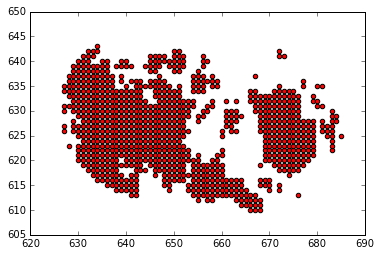

In [97]:
for xyz in sunspot_points:
    plt.scatter(xyz[1], xyz[0], c='r',marker='o');

###To Be Contnued...

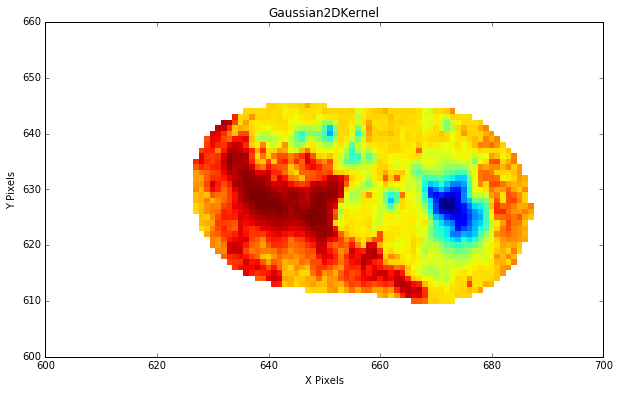

In [9]:
plot_image(active_region_image[0])

#Convolve Image Then Cluster